In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

from IPython import display
import time
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

<IPython.core.display.Javascript object>


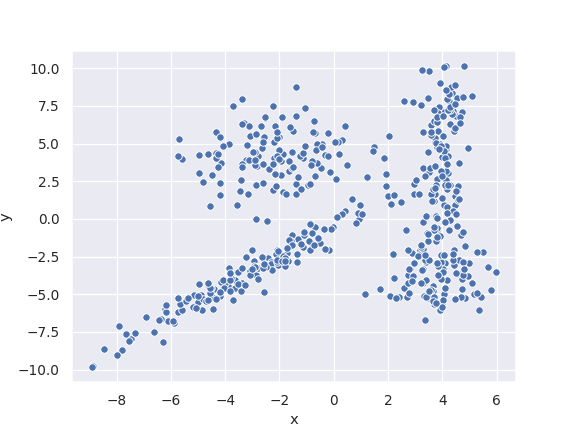

In [3]:
plt.figure()
sns.scatterplot(x="x", y="y", data=data_train);

<IPython.core.display.Javascript object>


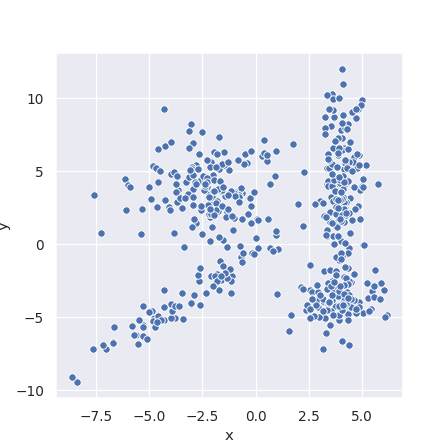

In [4]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="x", y="y", data=data_test);

# K-means

In [5]:
def Jfunc(X, mu, z, k):
    J=0
    for i in range(k):
         J+=np.sum(np.power(np.linalg.norm(X[z==i]-mu[i,:],axis=1),2))
    return J

In [6]:
def kmeans(X, k, eps, display='all', timing=0.4):
    #initialization
    mu = X[np.random.randint(0, X.shape[0],k),:]
    convergence = False
    
    if display=='all':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        palette =  ['red', 'blue', 'green', 'purple']
        plt.ion()
        ax.clear()
        ax.scatter(x=X[:,0], y=X[:,1], c='red')
        ax.scatter(x=mu[:,0],y=mu[:,1],c='black',marker='X')
        fig.canvas.draw()   # draw
        time.sleep(timing)    #sleep
        fig.show();
        
    j = np.inf

    while not(convergence):
        #optimize over z
        z = np.argmin(distance_matrix(X, mu),axis=1)
        
        if display=='all':
            ax.clear() # - Clear
            sns.scatterplot(x=X[:,0], y=X[:,1], hue=z, palette=palette)
            fig.canvas.draw()   # draw
            time.sleep(timing)    #sleep
        
        #optimize over mu
        for i in range(0,k):
            mu[i,:] = X[z==i].mean(axis=0)
            
        if display == 'all':
            ax.scatter(x=mu[:,0],y=mu[:,1],c='black',marker='X')
            fig.canvas.draw()   # draw
            time.sleep(timing) 
            
        #convergence evaluation
        if np.abs(j-Jfunc(X, mu, z, k))<eps:
            convergence = True
        else:
            j = Jfunc(X, mu, z, k)
        
        if display == 'all':
            fig.canvas.set_window_title('J: {}'.format(j))
    return mu, z

<IPython.core.display.Javascript object>


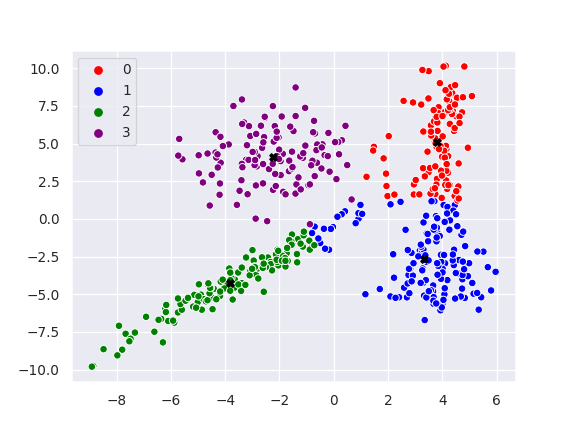

In [7]:
mu, z = kmeans(data_train.values, 4, 0.1, display='all', timing=0.2)

In [8]:
cmaps_dic={'blue':'Blues',
           'red':'Reds',
           'green':'Greens',
           'purple':'Purples',
           'grey': 'Greys',
           'orange':'Oranges'}
palette = ['red', 'blue', 'green', 'purple', 'grey', 'orange']

In [9]:
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """
    Create a grid in the form of a list of points stored in a 2D array
    """

    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:, 0]),  np.min(data[:, 0]), np.max(data[:, 1]), np.min(data[:, 1])

    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1./step), np.arange(ymin, ymax, (ymax-ymin)*1./step))
    grid = np.c_[x.ravel(), y.ravel()]

    return grid, x, y

In [10]:
class GaussianMixture():
    
    def __init__(self, X, k, covariance_mode, eps=0.1, n_itermax=100, display='all', timing=0.1):
        #input parameters
        self.X = X
        self.k = k
        self.covariance_mode = covariance_mode
        self.eps = eps #criteria threshold
        self.n_itermax = n_itermax 
        
        
        # kmeans initialization
        mu,tau = kmeans(X,k,0.1,display=None)
        self.tau = pd.get_dummies(tau).values.astype(float)
        
        # Gaussians mean and covariance matrix init
        self.mus = np.zeros((self.X.shape[1],k))
        if covariance_mode == 'isotrope':
            self.sigmas = np.zeros(k)
        else:
            self.sigmas = np.zeros((k,self.X.shape[1],self.X.shape[1]))
        
        #Compute mean and cov knowing tau
        self.m_step()
        
        # display settings
        if display=='all':
            self.timing = timing
            self.set_display()
            self.display()
        
    def set_display(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        self.palette =  np.random.permutation(palette)[:self.k].tolist()
        plt.ion()

        #grid to display gaussian densities
        grid, x_grid, y_grid = make_grid(data=self.X, step=100)
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.grid = grid
        self.ax.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
            
    def display(self):
        self.ax.clear()
        for j in range(self.k):
            self.ax.contour(self.x_grid,
                            self.y_grid,
                            multivariate_normal.pdf(self.grid, 
                                                    mean=self.mus[:, j], 
                                                    cov=self.sigmas[j]).reshape(self.x_grid.shape),
                            levels = 15,
                            alpha=0.6,
                            linestyles='solid',
                            cmap =cmaps_dic[self.palette[j]])

        sns.scatterplot(x=self.X[:,0], y=self.X[:,1], hue=np.argmax(self.tau,axis=1), palette=self.palette)
        self.ax.scatter(x=self.mus[0,:],y=self.mus[1,:],c='black',marker='X')
        self.fig.canvas.draw()  # draw
        time.sleep(self.timing)  #sleep
            
    def e_step(self):
        for j in range(self.k):
                self.tau[:, j] = self.pis[j] * multivariate_normal.pdf(self.X, 
                                                                       mean=self.mus[:, j], 
                                                                       cov=self.sigmas[j])
        self.tau = self.tau / self.tau.sum(axis=1).reshape(-1,1)
        

    def m_step(self):
        self.pis = self.tau.mean(axis=0)
        for i in range(self.k):
            self.mus[:,i] = (self.X*(self.tau[:,i].reshape(-1,1))).sum(axis=0)/self.tau[:,i].sum()
            
        if self.covariance_mode == 'isotrope':
            for i in range(self.k):
                self.sigmas[i]=np.sqrt((self.X - self.mus[:,i]).dot((self.X-self.mus[:,i]).T).dot(np.diag(self.tau[:,i])).trace()/np.diag(self.tau[:,i]).sum())
        else:
            for i in range(self.k):
                self.sigmas[i]=((self.X - self.mus[:,i]).T.dot(np.diag(self.tau[:,i]))).dot(self.X-self.mus[:,i])/np.diag(self.tau[:,i]).sum()
    
    def jfunc(self):
        res=0
        for j in range(self.k):
            log_pdf = np.log(multivariate_normal.pdf(self.X, mean=self.mus[:, j], cov=self.sigmas[j]))
            res += (self.tau[:,j] * log_pdf).sum() + (self.tau[:,j] * np.log(self.pis[j])).sum()
        return res
    
    def fit(self):
        convergence = False
        niter = 1
        self.j = np.inf 
        while not(convergence):
            self.e_step()
            self.m_step()
            self.display()
            if (np.abs(self.j-self.jfunc())<self.eps) or (niter > self.n_itermax):
                convergence = True
            else:
                self.j = self.jfunc()
                niter+=1

<IPython.core.display.Javascript object>


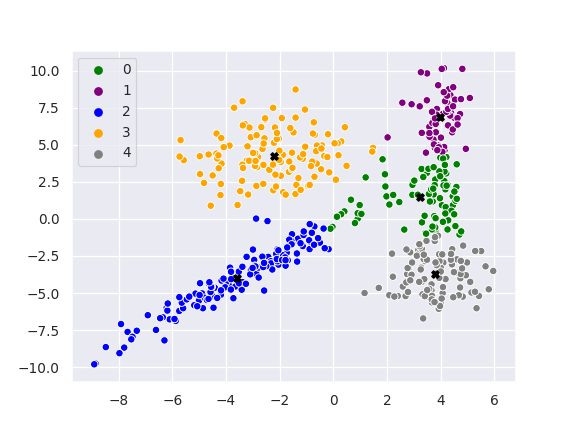

/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/

/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sonia/anaconda3/lib/python3.7/site-packages/

In [11]:
g = GaussianMixture(data_train.values, 5,'isotrope')
g.fit()